In [1]:
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('DP').getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/11 05:36:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
#DP

#Read in and display the data in dataset
df_demog=spark.read.csv('BDAS_Iteration_Dataset/demographic.csv', header=True, inferSchema=True)
df_happy=spark.read.csv('BDAS_Iteration_Dataset/cleaned_hm.csv', header=True, inferSchema=True)
df_demog.show()
df_happy.show()

+---+----+-------+------+--------+----------+
|wid| age|country|gender| marital|parenthood|
+---+----+-------+------+--------+----------+
|  1|37.0|    USA|     m| married|         y|
|  2|29.0|    IND|     m| married|         y|
|  3|  25|    IND|     m|  single|         n|
|  4|  32|    USA|     m| married|         y|
|  5|  29|    USA|     m| married|         y|
|  6|  35|    IND|     m| married|         y|
|  7|  34|    USA|     m| married|         y|
|  8|  29|    VNM|     m|  single|         n|
|  9|  61|    USA|     f| married|         y|
| 10|  27|    USA|     m|  single|         n|
| 11|45.0|    USA|     m|divorced|         n|
| 12|  25|    USA|     f|  single|         n|
| 13|45.0|    IND|     m| married|         y|
| 14|25.0|    IND|     m| married|         y|
| 15|  27|    USA|     m| married|         y|
| 16|35.0|    USA|     m|  single|         n|
| 17|30.0|    USA|     m|  single|         n|
| 18|  30|    USA|     m|  single|         n|
| 19|  29|    USA|     m| married|

In [3]:
print('Number of rows in demographic file:', df_demog.count())
print('Number of rows in happy moment file:', df_happy.count())

Number of rows in demographic file: 10844
Number of rows in happy moment file: 106401


In [4]:
#Data Selection

# Drop multiple unused columns in df_happy
columns_to_drop = ['hmid', 'reflection_period', 'original_hm', 'cleaned_hm', 'modified', 'num_sentence', 'ground_truth_category']
dropped_happy_df = df_happy.drop(*columns_to_drop)
dropped_happy_df.count()
dropped_happy_df.show()

+----+------------------+
| wid|predicted_category|
+----+------------------+
|2053|         affection|
|   2|         affection|
|1936|          exercise|
| 206|           bonding|
|6227|              null|
|null|              null|
|null|              null|
|  45|           leisure|
| 195|       achievement|
| 740|         affection|
|   3|  enjoy_the_moment|
|4833|         affection|
|7334|           leisure|
|  78|          exercise|
|  21|           bonding|
|   8|       achievement|
| 586|  enjoy_the_moment|
| 489|         affection|
| 976|           bonding|
|3972|       achievement|
+----+------------------+
only showing top 20 rows



In [5]:
# Import the modified Happy moment file and replace the current one for happy_df
df_happy=spark.read.csv('BDAS_Iteration_Dataset/cleaned_hm_01.csv', header=True, inferSchema=True)
df_happy.show()
df_happy.count()

+----+------------------+
| wid|predicted_category|
+----+------------------+
|2053|         affection|
|   2|         affection|
|1936|          exercise|
| 206|           bonding|
|6227|         affection|
|  45|           leisure|
| 195|       achievement|
| 740|         affection|
|   3|  enjoy_the_moment|
|4833|         affection|
|7334|           leisure|
|  78|          exercise|
|  21|           bonding|
|   8|       achievement|
| 586|  enjoy_the_moment|
| 489|         affection|
| 976|           bonding|
|3972|       achievement|
|  14|           bonding|
|1230|         affection|
+----+------------------+
only showing top 20 rows



100535

In [11]:
from pyspark.sql.functions import col, isnull, count, when, isnan

# Count the rows with null values in the entire DataFrame
count_null_rows = df_happy.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_happy.columns]).collect()[0]
for column in df_happy.columns:
    print(f"{column}: {count_null_rows[column]}")

wid: 0
predicted_category: 0


In [12]:
# Count the rows with null values in the entire DataFrame
count_null_rows = df_demog.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_demog.columns]).collect()[0]

print("Count of rows with null values in the DataFrame:")
for column in df_demog.columns:
    print(f"{column}: {count_null_rows[column]}")

Count of rows with null values in the DataFrame:
wid: 0
age: 35
country: 73
gender: 32
marital: 57
parenthood: 31


In [14]:
df_demog = df_demog.na.drop()
df_demog.count()

10689

In [15]:
count_null_rows = df_demog.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_demog.columns]).collect()[0]

print("Count of rows with null values in the DataFrame:")
for column in df_demog.columns:
    print(f"{column}: {count_null_rows[column]}")

Count of rows with null values in the DataFrame:
wid: 0
age: 0
country: 0
gender: 0
marital: 0
parenthood: 0


In [16]:
# Filter out non-numeric responses in the 'age' column
non_numeric_age_count = df_demog.filter(~col('age').cast('int').isNotNull()).count()

print(f"Count of non-numeric responses in the 'age' column: {non_numeric_age_count}")

non_numeric_age_df = df_demog.filter(~col('age').cast('int').isNotNull())
non_numeric_age_df.show()

Count of non-numeric responses in the 'age' column: 3
+-----+-----------------+-------+------+--------+----------+
|  wid|              age|country|gender| marital|parenthood|
+-----+-----------------+-------+------+--------+----------+
|  317|prefer not to say|    USA|     m|  single|         n|
| 8086|               čá|    GBR|     m|divorced|         y|
|12276|            60yrs|    USA|     f|  single|         y|
+-----+-----------------+-------+------+--------+----------+



In [18]:
from pyspark.sql.functions import avg

# Step 1: Calculate the average age
average_age = df_demog.select(avg(col('age'))).collect()[0][0]

# Step 2: Replace non-numeric age values with the average age
df_demog = df_demog.withColumn('age', when(col('age').cast('int').isNotNull(), col('age')).otherwise(average_age))

non_numeric_age_count = df_demog.filter(~col('age').cast('int').isNotNull()).count()

print(f"Count of non-numeric responses in the 'age' column: {non_numeric_age_count}")

Count of non-numeric responses in the 'age' column: 0


+----+-----+
| age|count|
+----+-----+
|  26|  354|
|  25|  353|
|  27|  335|
|  29|  317|
|  30|  315|
|  24|  299|
|  28|  297|
|  31|  280|
|  32|  272|
|  23|  262|
|26.0|  258|
|27.0|  257|
|25.0|  246|
|28.0|  244|
|29.0|  236|
|  34|  232|
|  22|  225|
|23.0|  223|
|30.0|  220|
|  33|  213|
+----+-----+
only showing top 20 rows



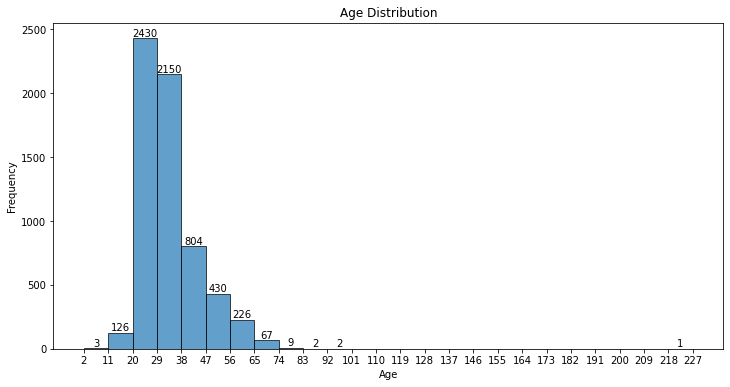

In [19]:
# Age
age_grouped_df = df_demog.groupBy('age')
result_df = age_grouped_df.count()
sorted_result_df = result_df.orderBy('count', ascending=False)
sorted_result_df.show()

#Data Visualizing

import matplotlib.pyplot as plt

# Filter out None and non-string values from the 'age' column
age_data = df_demog.filter(df_demog['age'].isNotNull() & (df_demog['age'] != '')).select('age').rdd.flatMap(lambda x: x).collect()

# Convert the 'age' values to integers for plotting
age_data = [int(age) for age in age_data if age.isdigit()]

# Create a histogram
plt.figure(figsize=(12, 6))
n, bins, patches = plt.hist(age_data, bins=25, edgecolor='k', alpha=0.7)

# Add labels and title
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution')

# Customize x-tick labels to display age values
plt.xticks(bins, [str(int(b)) for b in bins])

# Add count labels to each bar
for count, patch in zip(n, patches):
    if count > 0:
        plt.text(patch.get_x() + patch.get_width() / 2, count, str(int(count)), ha='center', va='bottom')

# Display the plot
plt.show()

In [20]:
# Cast the 'age' column to integer
df_demog = df_demog.withColumn('age', col('age').cast('int'))

# Show the DataFrame with 'age' column as integers
age_grouped_df = df_demog.groupBy('age')
result_df = age_grouped_df.count()
sorted_result_df = result_df.orderBy('count', ascending=False)
sorted_result_df.show()

+---+-----+
|age|count|
+---+-----+
| 26|  612|
| 25|  599|
| 27|  592|
| 29|  553|
| 28|  541|
| 30|  535|
| 23|  485|
| 24|  482|
| 32|  465|
| 31|  437|
| 22|  408|
| 34|  387|
| 33|  371|
| 35|  350|
| 21|  322|
| 36|  305|
| 37|  233|
| 38|  225|
| 20|  213|
| 40|  183|
+---+-----+
only showing top 20 rows



In [23]:
# Specify the column to check for outliers
column_name = 'age'  # Replace with the actual column name

# Calculate quartiles
q1 = df_demog.approxQuantile(column_name, [0.25], 0.01)[0]
q3 = df_demog.approxQuantile(column_name, [0.75], 0.01)[0]

# Calculate the IQR
iqr = q3 - q1

# Define lower and upper bounds
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Identify outliers
outliers = df_demog.filter((col(column_name) < lower_bound) | (col(column_name) > upper_bound))

# Show the outliers
outliers.show()

+---+---+-------+------+---------+----------+
|wid|age|country|gender|  marital|parenthood|
+---+---+-------+------+---------+----------+
|  9| 61|    USA|     f|  married|         y|
| 48| 57|    USA|     f|  married|         n|
| 62|  3|    IND|     m|   single|         n|
|109| 65|    USA|     m|  married|         y|
|113| 59|    USA|     f|   single|         n|
|121| 57|    USA|     f| divorced|         y|
|150| 69|    USA|     m|  married|         y|
|170| 68|    USA|     f|separated|         y|
|252| 56|    USA|     f|   single|         n|
|276| 68|    USA|     m|  married|         y|
|290| 62|    USA|     f|  married|         y|
|291| 70|    USA|     m|  married|         y|
|310| 83|    USA|     m|  married|         y|
|315| 74|    USA|     f|  married|         y|
|331| 61|    USA|     f|  married|         n|
|383| 66|    USA|     m|  married|         y|
|389| 61|    USA|     f|  married|         y|
|461| 61|    USA|     f|  married|         y|
|474| 58|    USA|     f|  married|

In [24]:
outliers.count()

498

In [25]:
print('lower_bound:', lower_bound)
print('upper_bound:', upper_bound)

lower_bound: 7.0
upper_bound: 55.0


In [26]:
# Filter the DataFrame to exclude outliers
outlier_cleaned_demog_df = df_demog.filter((col(column_name) >= lower_bound) & (col(column_name) <= upper_bound))

outlier_cleaned_demog_df.count()

10191

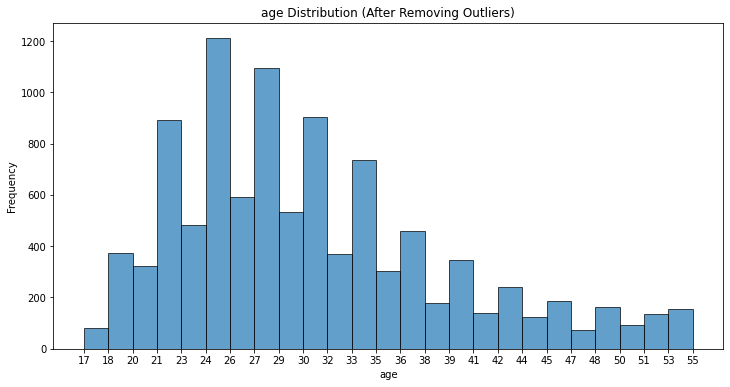

In [28]:
column_name = 'age'

# Extract the column data
age_data = outlier_cleaned_demog_df.select(column_name).rdd.flatMap(lambda x: x).collect()

# Create a histogram
plt.figure(figsize=(12, 6))
n, bins, patches = plt.hist(age_data, bins=25, edgecolor='k', alpha=0.7)

# Add labels and title
plt.xlabel(column_name)
plt.ylabel('Frequency')
plt.title(f'{column_name} Distribution (After Removing Outliers)')

# Customize x-tick labels
plt.xticks(bins, [str(int(b)) for b in bins])

# Display the plot
plt.show()